In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

%cd C:/Users/piai/Desktop/work/CycleGAN_Project_1/

C:\Users\piai\Desktop\work\CycleGAN_Project_1


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\piai\appdata\local\temp\pip-req-build-08sorrrl
  Resolved https://github.com/tensorflow/examples.git to commit f2b560e341ee0b21f1b8a0f351077a656fff7336
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\piai\AppData\Local\Temp\pip-req-build-08sorrrl'


In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch

In [8]:
num_epochs = 10
batchsize = 100
lr_gen = 0.001
lr_disc = 0.0005
root = "C:/Users/piai/Desktop/work/CycleGAN_Project_1/datasets/horse2zebra/"

In [9]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset_A = torchvision.datasets.ImageFolder(root+'/train/trainA', transform)

In [10]:
trainset_B = torchvision.datasets.ImageFolder(root = root+'/train/trainB', transform = transform)

In [11]:
trainloader_A = DataLoader(trainset_A,
                         batch_size = batchsize,
                         shuffle = True,
                         num_workers = 4)

In [12]:
trainloader_B = DataLoader(trainset_B,
                         batch_size = batchsize,
                         shuffle = True,
                         num_workers = 4)

In [13]:
testset_A = torchvision.datasets.ImageFolder(root = root+"/test/testA", transform = transform)

In [14]:
testset_B = torchvision.datasets.ImageFolder(root = root+"/test/testB", transform = transform)

In [15]:
testloader_A = DataLoader(testset_A,
                         batch_size = batchsize,
                         shuffle = False,
                         num_workers = 4)

testloader_B = DataLoader(testset_B,
                         batch_size = batchsize,
                         shuffle = False,
                         num_workers = 4)

In [16]:
sample_A = next(iter(trainloader_A))
sample_B = next(iter(trainloader_B))

In [17]:
sample_A[0].shape

torch.Size([100, 3, 256, 256])

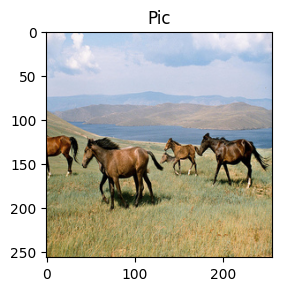

In [18]:
plt.subplot(121)
plt.title('Pic')
plt.imshow(sample_A[0].permute(0,2,3,1)[0] * 0.5 + 0.5)

In [19]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [20]:
to_B = generator_g(tf.reshape(sample_A[0].permute(0,2,3,1)[0], [1, 256, 256, 3]))
to_A = generator_f(tf.reshape(sample_B[0].permute(0,2,3,1)[0], [1, 256, 256, 3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


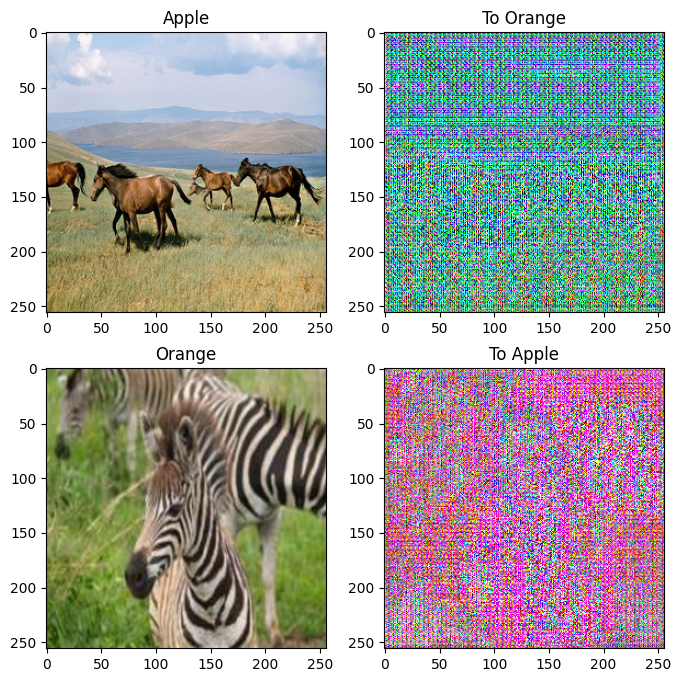

In [21]:
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [tf.reshape(sample_A[0].permute(0,2,3,1)[0], [1, 256, 256, 3]), to_B, tf.reshape(sample_B[0].permute(0,2,3,1)[0], [1, 256, 256, 3]), to_A]
title = ['A', 'To B', 'B', 'To A']


for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [22]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [24]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [25]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [26]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [27]:
generator_g_optimizer = tf.keras.optimizers.Adam(lr_gen, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(lr_gen, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(lr_disc, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(lr_disc, beta_1=0.5)

In [28]:
train_G_loss = tf.keras.metrics.Mean()
train_D_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
test_loss = tf.keras.metrics.Mean()
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [29]:
"""checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')"""

'checkpoint_path = "./checkpoints/train"\n\nckpt = tf.train.Checkpoint(generator_g=generator_g,\n                           generator_f=generator_f,\n                           discriminator_x=discriminator_x,\n                           discriminator_y=discriminator_y,\n                           generator_g_optimizer=generator_g_optimizer,\n                           generator_f_optimizer=generator_f_optimizer,\n                           discriminator_x_optimizer=discriminator_x_optimizer,\n                           discriminator_y_optimizer=discriminator_y_optimizer)\n\nckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)\n\n# if a checkpoint exists, restore the latest checkpoint.\nif ckpt_manager.latest_checkpoint:\n  ckpt.restore(ckpt_manager.latest_checkpoint)\n  print (\'Latest checkpoint restored!!\')'

In [30]:
EPOCHS = num_epochs

In [31]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [32]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  train_G_loss(total_gen_g_loss)
  train_D_loss(disc_y_loss)

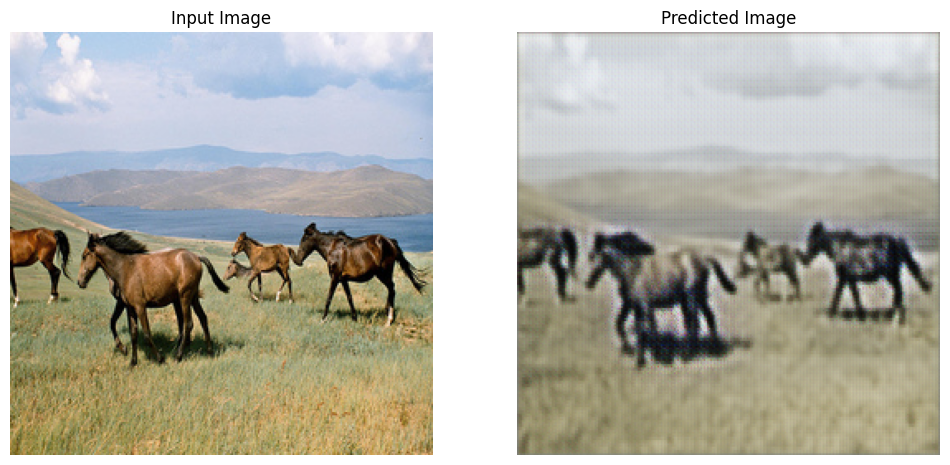

Time taken for epoch 3 is 57.25071120262146 sec

Epoch 3 generation loss: 7.692950248718262 disrtimination loss : 0.9387548565864563


In [ ]:
from tqdm.notebook import tqdm

g=[]
d=[]

for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  n = 0
  for i, (image_x, image_y) in enumerate(zip(trainloader_A, trainloader_B)):
    image_x = tf.reshape(image_x[0].permute(0,2,3,1)[0], [1, 256, 256, 3])
    image_y = tf.reshape(image_y[0].permute(0,2,3,1)[0], [1, 256, 256, 3])
    train_step(image_x, image_y)
    
    if n % 100 == 0:
      print ('.', end='')
    n += 1

  print ("Epoch {} generation loss : ".format(epoch), g)
  print ("Epoch {} discrimination loss : ".format(epoch), d)

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.

  generate_images(generator_g, tf.reshape(sample_A[0].permute(0,2,3,1)[0], [1, 256, 256, 3]))
  

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
  g.append(train_G_loss.result())
  d.append(train_D_loss.result())
  print ("Epoch {} generation loss: {} disrtimination loss : {}".format(epoch+1, train_G_loss.result(), train_D_loss.result()))

In [ ]:
plt.title("Generator Loss per iterations")
plt.xlabel("Epochs")
plt.ylabel("Generator Loss")
plt.plot(g)

In [ ]:
plt.title("Discriminator Loss per iterations")
plt.xlabel("Epochs")
plt.ylabel("Discriminator Loss")
plt.plot(d)

Generation

In [45]:
testloader_A = DataLoader(testset_A,
                         batch_size = 1,
                         shuffle = False,
                         num_workers = 4)

for i, image in enumerate(testloader_A):
  image = tf.reshape(image[0].permute(0,2,3,1)[0], [1, 256, 256, 3])
  generate_images(generator_g, image)
  plt.savefig('output/output_image/output_image/horse2zebra/horse2zebra'+str(format(i, '02'))+'.png')
  if i == 19:
    break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# yonseiset = torchvision.datasets.ImageFolder(root = root+"/yonsei", transform = transform)

In [ ]:
# yonseiloader = DataLoader(yonseiset,
#                          batch_size = 1,
#                          shuffle = False,
#                          num_workers = 4)

# for i, image in enumerate(yonseiloader):
#   image = tf.reshape(image[0].permute(0,2,3,1)[0], [1, 256, 256, 3])
#   generate_images(generator_g, image)